In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import math as m
import random as rnd
from pathlib import Path
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


In [4]:
from utils.calibration import clalibrate_camera, get_object_points

In [5]:
calibration_images = [cv2.imread('camera_cal/'+img) for img in os.listdir("camera_cal/")]
mtx, dist, rvecs, tvecs = clalibrate_camera(calibration_images)

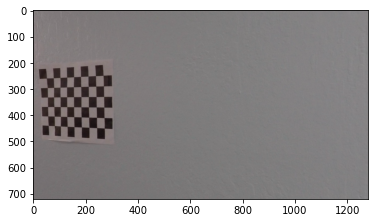

In [30]:
  plt.imshow(cv2.undistort(calibration_images[2], mtx, dist, None))

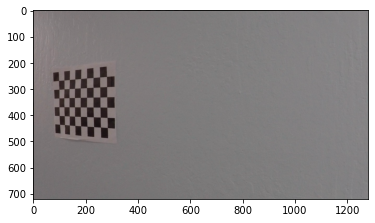

In [31]:
plt.imshow(cv2.imread('camera_cal/' + os.listdir('camera_cal/')[2]))

In [34]:
test_img = cv2.imread('test_images/test1.jpg')

In [37]:
# cv2.imshow('img',test_img)
# cv2.waitKey(500)

-1

In [38]:

# cv2.destroyAllWindows()

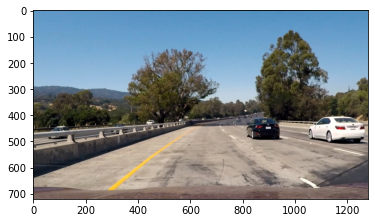

In [41]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [42]:
test_img = cv2.undistort(test_img, mtx, dist, None)

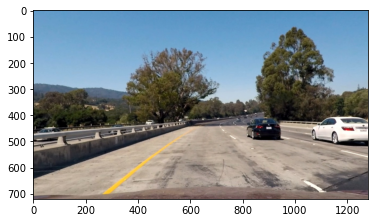

In [43]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))